In [2]:
import numpy as np
import pandas as pd
import json
import folium
from branca.colormap import linear
from matplotlib import pyplot as plt

In [2]:
%qtconsole
%matplotlib inline

/usr/local/lib/python3.4/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Pandas df

In [19]:
postal_count = pd.read_csv('/media/flo/Stockage/Data/MesAides/tables/postal_count.csv')
del postal_count['Unnamed: 0']

In [20]:
postal_count.head(2)

,Code_commune_INSEE,CP_count
0,50173,0.0
1,06079,0.0


In [21]:
postal_count_dict = postal_count.set_index('Code_commune_INSEE')['CP_count']
postal_count_dict = postal_count_dict.to_dict()
postal_count_dict['65405']

0.0

In [22]:
postal_count.Code_commune_INSEE = postal_count.Code_commune_INSEE.astype(str)
postal_count.CP_count = postal_count.CP_count.astype(int)

### GeoJSON

In [6]:
geo_json_data = json.load(open('/media/flo/Stockage/Data/communes_osm/communes_100m/simplified_communes100m.json'))

### Map

In [ ]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)
folium.GeoJson(geo_json_data).add_to(map_france)
map_france

In [ ]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)
map_france.choropleth(geo_str=open('/media/flo/Stockage/Data/communes_osm/communes_100m/simplified_communes100m.json').read())
map_france.save('/media/flo/Stockage/Data/MesAides/map/TESTMAP.html')

In [43]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(map_france)

map_france.save('/media/flo/Stockage/Data/MesAides/map/geojson_test2.html')

In [79]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': colormap(postal_count_dict[feature["geometry.properties.insee"]]),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : .9,
        }
    ).add_to(map_france)

map_france.save('/media/flo/Stockage/Data/MesAides/map/choro_test1.html')

KeyError: 'geometry.properties.insee'

## Choropleth

In [202]:
postal_count[postal_count.CP_count != 0].sort_values(by='CP_count', ascending=False).head()

,Code_commune_INSEE,CP_count
220,31555,1249
877,44109,910
18,34172,823
3139,33063,733
1339,67482,723


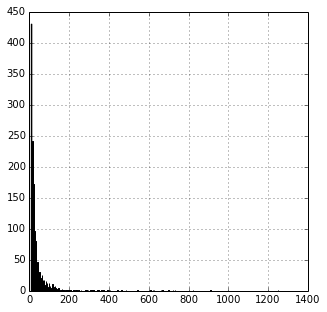

In [17]:
postal_count.CP_count[postal_count.CP_count > 10].hist(bins=500, figsize=(5, 5))

In [19]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

map_france.choropleth(
                    geo_str=open('/media/flo/Stockage/Data/communes_osm/communes_100m/simplified_communes100m.json').read(),
                    data=postal_count,
                    columns=['Code_commune_INSEE', 'CP_count'],
                    key_on='feature.properties.insee',
                    fill_color='BuPu',
                    line_opacity=0.05,
                    line_weight=0.3,
                    line_color='grey',
                    threshold_scale=[10.0, 50.0, 90.0, 150.0, 200.0, 500.0],
                    legend_name='Nombre de simulations',
)
map_france.save('/media/flo/Stockage/Data/MesAides/map/choro_test1.html')

In [20]:
# map_france
# voir le HTML dictement.

### Choropleth normalisé par la population par code_insee

In [23]:
# recencement 2013
t_populations = pd.read_excel('/media/flo/Stockage/Data/communes_osm/population_communes_insee/ensemble.xls',
                              skiprows=7,
                              sheetname='Communes',
                              converters={'Code région': str, 'Code commune': str, 'Code département': str}
                             )
# code insee = code département & code commune
t_populations['Code_commune_INSEE'] = t_populations[['Code département', 'Code commune']].astype(str).sum(axis=1)

t_populations.head(2)

,Code région,Nom de la région,Code département,Code arrondissement,Code canton,Code commune,Nom de la commune,Population municipale,Population comptée à part,Population totale,Code_commune_INSEE
0,82,Rhône-Alpes,01,2,8.0,001,L' Abergement-Clémenciat,767,13,780,01001
1,82,Rhône-Alpes,01,1,1.0,002,L' Abergement-de-Varey,236,4,240,01002


In [24]:
postal_count = pd.merge(postal_count,
               t_populations.ix[:, ['Code_commune_INSEE', 'Population totale', 'Nom de la commune']],
               on='Code_commune_INSEE',
               how='left')

postal_count.head(2)

,Code_commune_INSEE,CP_count,Population totale,Nom de la commune
0,50173,0,17841.0,Équeurdreville-Hainneville
1,06079,0,23095.0,Mandelieu-la-Napoule


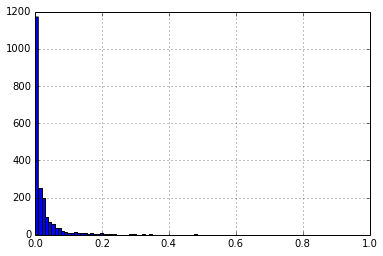

In [27]:
postal_count['ratio'] = postal_count['CP_count'] / postal_count['Population totale']
postal_count[postal_count.CP_count > 10].ratio.hist(bins=100)

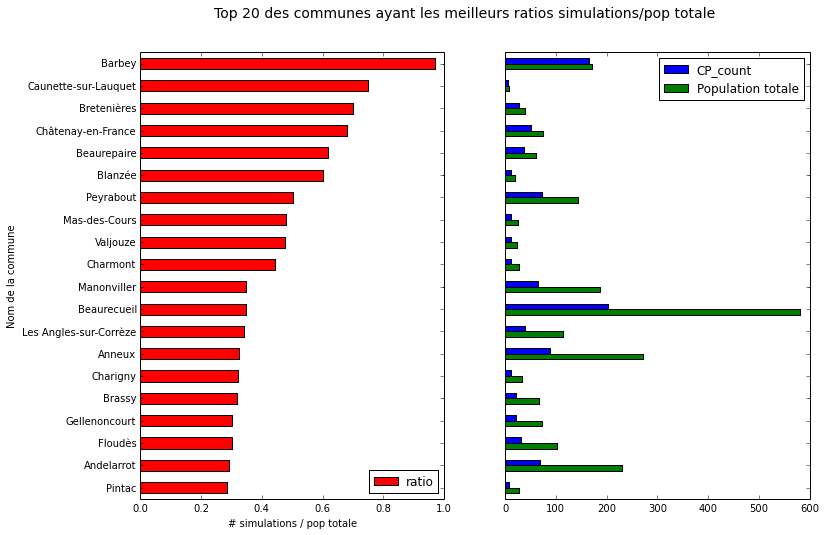

In [28]:
fig = plt.figure(figsize=(12, 8))
ax0 = plt.subplot(121)
postal_count.sort_values('ratio', ascending=False).head(20).plot(kind='barh',
                                                                 x='Nom de la commune',
                                                                 y='ratio',
                                                                 ax=ax0,
                                                                 color='red')
plt.gca().invert_yaxis()
plt.xlabel('# simulations / pop totale')
plt.legend(loc='lower right')

ax1 = plt.subplot(122, sharey=ax0)
postal_count.sort_values('ratio', ascending=False).head(20).plot(kind='barh',
                                                                 x='Nom de la commune',
                                                                 y=['CP_count', 'Population totale'],
                                                                 ax=ax1)

plt.gca().invert_yaxis()

plt.suptitle('Top 20 des communes ayant les meilleurs ratios simulations/pop totale', fontsize=14)

In [121]:
from folium.utilities import split_six

In [29]:
postal_count_filter = postal_count.copy()

In [30]:
postal_count_filter.loc[(postal_count_filter['Population totale'] > 5000) & postal_count_filter['Population totale'] < 20000]['ratio'] =  -1

In [49]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

map_france.choropleth(
                    geo_str=open('/media/flo/Stockage/Data/communes_osm/communes_100m/simplified_communes100m.json').read(),
                    data=postal_count,
                    columns=['Code_commune_INSEE', 'ratio'],
                    key_on='feature.properties.insee',
                    fill_color='RdPu',
                    line_opacity=0.05,
                    fill_opacity=0.8,
                    line_weight=0.3,
                    line_color='grey',
                    #threshold_scale=[0.015, 0.05, 0.1, 0.2, 0.3, 0.5],
                    legend_name='Nombre de simulations normalisé par la population'
)
map_france.save('/media/flo/Stockage/Data/MesAides/map/choro_ratio_f5000.html')

## Indice pauvreté

L'indicateur choisi est le "MED12" (Médiane du revenu disponible par unité de consommation (en euros)).

L'indicateur n'est pas optimal, mais il est disponible sur un maximum de communes (contraitement au taux de pauvreté 2011)

La base est dispo ici : http://www.insee.fr/fr/themes/detail.asp?reg_id=99&ref_id=revenu-pauvrete-menage



In [57]:
%qtconsole

In [31]:
# recencement 2012
t_pauvrete = pd.read_excel('/media/flo/Stockage/Data/communes_osm/pauvrete_insee/base-cc-filosofi-12.xls',
                              skiprows=5,
                              sheetname='COM',
                              converters={'CODGEO': str, 'LIBGEO': str}
                             )
t_pauvrete.rename(columns={'CODGEO': 'Code_commune_INSEE',
                           'NBMENFISC12': 'nb_menages_fiscaux',
                           'NBPERSMENFISC12': 'nb_pers_menages_fiscaux'}, inplace=True)
t_pauvrete.head(2)

,Code_commune_INSEE,LIBGEO,nb_menages_fiscaux,nb_pers_menages_fiscaux,MED12,PIMP12,TP6012,TP60AGE112,TP60AGE212,TP60AGE312,...,PPEN12,PPAT12,PPSOC12,PPFAM12,PPMINI12,PPLOGT12,PIMPOT12,RD12,D112,D912
0,01001,L'Abergement-Clémenciat,299.0,780.5,22253.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01002,L'Abergement-de-Varey,97.0,227.0,21765.714286,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
t_pauvrete = t_pauvrete.ix[:, ['Code_commune_INSEE', 'nb_menages_fiscaux', 'nb_pers_menages_fiscaux', 'MED12']]
t_pauvrete.head()

,Code_commune_INSEE,nb_menages_fiscaux,nb_pers_menages_fiscaux,MED12
0,01001,299.0,780.5,22253.000000
1,01002,97.0,227.0,21765.714286
2,01004,5897.0,13420.0,19236.666667
3,01005,615.0,1673.5,21743.888889
4,01006,48.0,111.0,20354.400000


In [33]:
postal_count = pd.merge(postal_count, t_pauvrete, on='Code_commune_INSEE', how='left')
postal_count.head(2)

,Code_commune_INSEE,CP_count,Population totale,Nom de la commune,ratio,nb_menages_fiscaux,nb_pers_menages_fiscaux,MED12
0,50173,0,17841.0,Équeurdreville-Hainneville,0.0,7309.0,16766.5,19459.500000
1,06079,0,23095.0,Mandelieu-la-Napoule,0.0,11938.0,23629.5,21251.904762


In [34]:
postal_count.head()

,Code_commune_INSEE,CP_count,Population totale,Nom de la commune,ratio,nb_menages_fiscaux,nb_pers_menages_fiscaux,MED12
0,50173,0,17841.0,Équeurdreville-Hainneville,0.000000,7309.0,16766.5,19459.500000
1,06079,0,23095.0,Mandelieu-la-Napoule,0.000000,11938.0,23629.5,21251.904762
2,12198,2,2087.0,Rieupeyroux,0.000958,848.0,1915.0,17715.200000
3,12108,0,371.0,Galgan,0.000000,150.0,364.0,16279.000000
4,75112,671,146251.0,Paris 12e Arrondissement,0.004588,69542.0,140838.0,26297.000000


In [35]:
postal_count.CP_count.corr(postal_count.MED12)

0.040376786721415217

In [36]:
postal_count.fillna(-1, inplace=True)

In [11]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

map_france.choropleth(
                    geo_str=open('/media/flo/Stockage/Data/communes_osm/communes_100m/simplified_communes100m.json').read(),
                    data=postal_count,
                    columns=['Code_commune_INSEE', 'MED12'],
                    key_on='feature.properties.insee',
                    fill_color='RdPu',
                    line_opacity=0.05,
                    fill_opacity=0.8,
                    line_weight=0.3,
                    line_color='grey',
                    #threshold_scale=[0.015, 0.05, 0.1, 0.2, 0.3, 0.5],
                    legend_name='MED12'
)
map_france.save('/media/flo/Stockage/Data/MesAides/map/choro_MED12.html')

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:14: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


KeyboardInterrupt: 

In [37]:
postal_count_0 = postal_count.loc[postal_count.ratio > 0.01]

In [38]:
postal_count_0.CP_count.corr(postal_count_0.MED12)

0.26256485861445178

In [39]:
postal_count.loc[postal_count.ratio > 0.01].count()

Code_commune_INSEE         1774
CP_count                   1774
Population totale          1774
Nom de la commune          1774
ratio                      1774
nb_menages_fiscaux         1774
nb_pers_menages_fiscaux    1774
MED12                      1774
dtype: int64

In [44]:
postal_count.sort_values('CP_count', ascending=False, inplace=True)
postal_count.head(2)

,Code_commune_INSEE,CP_count,Population totale,Nom de la commune,ratio,nb_menages_fiscaux,nb_pers_menages_fiscaux,MED12
220,31555,1249,466219.0,Toulouse,0.002679,199133.0,390004.0,19883.2
877,44109,910,300614.0,Nantes,0.003027,128714.0,259208.5,20413.0


In [242]:
postal_count.sort_values('CP_count', ascending=False, inplace=True)
l_corr = []
l_nb_simul = []
l_min_simul = []
top_thresh = np.arange(10, 500, 10)
for n in top_thresh:
    l_corr.append(postal_count.CP_count.head(n).corr(postal_count.MED12.head(n)))
    l_min_simul.append(postal_count.CP_count.head(n).min())

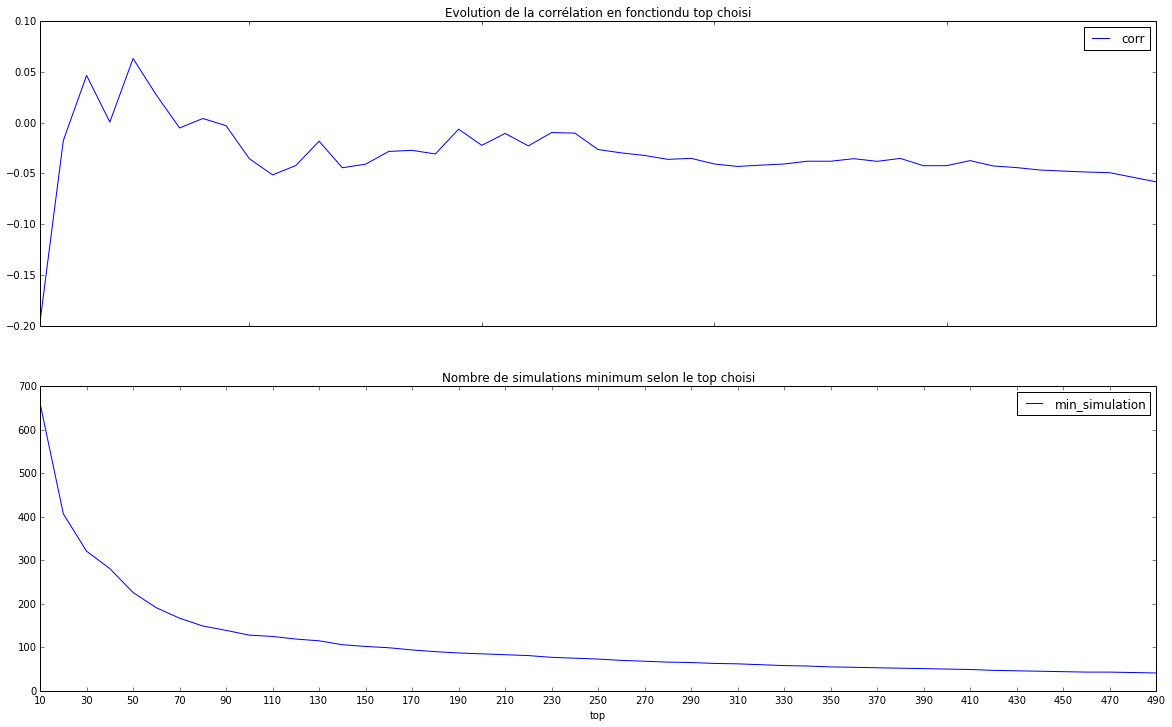

In [249]:
df_res = pd.DataFrame()
df_res['corr'] = l_corr

fig = plt.figure(figsize=(20, 12))
ax0 = plt.subplot(211)
df_res['top'] = top_thresh
df_res.plot(x='top', y='corr', fig=fig, ax=ax0)
plt.title('Evolution de la corrélation en fonctiondu top choisi')
ax1 = plt.subplot(212)
df_res['min_simulation'] = l_min_simul
df_res.plot(x='top', y='min_simulation', sharex=True, ax=ax1, fig=fig, xticks=top_thresh[::2])
plt.title('Nombre de simulations minimum selon le top choisi')